 Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Task 1: Data Preparation

In [5]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import to_categorical
from google.colab import drive




train_dir = '/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Train'
test_dir = '/content/drive/MyDrive/DevanagariHandwrittenDigitDataset/Test'

# Define image size and number of classes
IMG_SIZE = (28, 28)
NUM_CLASSES = 10

def load_data(data_dir):
    images = []
    labels = []
    classes = sorted(os.listdir(data_dir))
    class_map = {cls: i for i, cls in enumerate(classes)}

    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert('L')
                img = img.resize(IMG_SIZE)
                img_array = np.array(img) / 255.0
                images.append(img_array)
                labels.append(class_map[cls])

    return np.array(images), np.array(labels)

# Load train and test data
X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)

# Reshape images to (28, 28, 1) for model compatibility
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (17010, 28, 28, 1), Labels shape: (17010, 10)
Testing data shape: (3020, 28, 28, 1), Labels shape: (3020, 10)


Task 2: Build the FCN Model

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the FCN model
def build_fcn_model(input_shape, num_classes):
    model = Sequential()

    # First convolutional block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Second convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Third convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Fourth convolutional block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Global average pooling to replace the Flatten layer
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    # Dense layer for classification (output layer)
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Input shape for the image (28x28 grayscale images)
input_shape = (28, 28, 1)
num_classes = 10  # Number of classes (digits 0-9)

# Build the model
fcn_model = build_fcn_model(input_shape, num_classes)

# Summary of the model
fcn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,410 (1.49 MB)

 Trainable params: 390,410 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Task 3: Compile the Model

In [16]:
# Compile the model
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Compile the FCN model
compiled_fcn_model = compile_model(fcn_model)

# Summary of the compiled model
compiled_fcn_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 390,410 (1.49 MB)

 Trainable params: 390,410 (1.49 MB)

 Non-trainable params: 0 (0.00 B)

Task 4: Train the Model

Epoch 1/20

Epoch 1: val_loss improved from inf to 56.97669, saving model to best_model.h5


107/107 - 9s - 82ms/step - accuracy: 0.7912 - loss: 0.6033 - val_accuracy: 5.8789e-04 - val_loss: 56.9767
Epoch 2/20

Epoch 2: val_loss did not improve from 56.97669
107/107 - 1s - 7ms/step - accuracy: 0.9697 - loss: 0.0920 - val_accuracy: 5.8789e-04 - val_loss: 67.0528
Epoch 3/20

Epoch 3: val_loss did not improve from 56.97669
107/107 - 1s - 8ms/step - accuracy: 0.9818 - loss: 0.0563 - val_accuracy: 5.8789e-04 - val_loss: 64.1233
Epoch 4/20

Epoch 4: val_loss did not improve from 56.97669
107/107 - 1s - 12ms/step - accuracy: 0.9915 - loss: 0.0287 - val_accuracy: 5.8789e-04 - val_loss: 66.1200
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


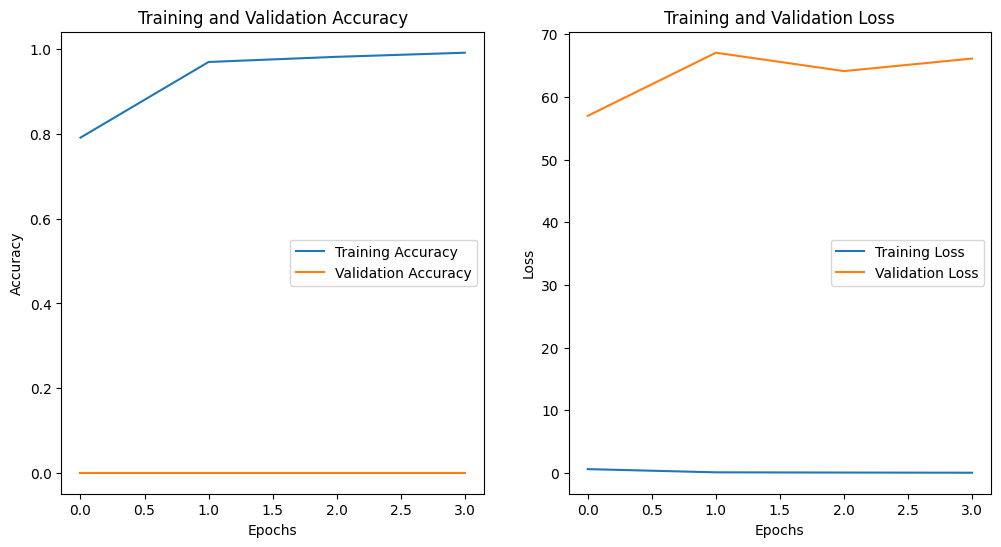

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks for model training
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = compiled_fcn_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20,
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=2
)

# Display training history
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Task 5: Evaluate the Model

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = compiled_fcn_model.evaluate(X_test, y_test, verbose=2)

# Display the test accuracy and loss
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


95/95 - 2s - 17ms/step - accuracy: 0.7192 - loss: 11.4606
Test Loss: 11.46062183380127
Test Accuracy: 71.92%


Task 6: Save and Load the Model

In [22]:
# Save the trained model to an .h5 file
compiled_fcn_model.save('devanagari_digit_model.h5')
print("Model saved successfully to 'devanagari_digit_model.h5'.")


loaded_model = tf.keras.models.load_model('/content/devanagari_digit_model.h5')
print("Model loaded successfully.")

# Evaluate the loaded model on the test set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test, verbose=2)

# Display the test accuracy and loss after loading the model
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Model saved successfully to 'devanagari_digit_model.h5'.
Model loaded successfully.
95/95 - 1s - 11ms/step - accuracy: 0.7192 - loss: 11.4606
Test Loss: 11.46062183380127
Test Accuracy: 71.92%


Task 7: Predictions

In [23]:
# Make predictions on the test set using the loaded model
predictions = loaded_model.predict(X_test)

# Convert the predicted probabilities to digit labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert the true labels back from one-hot encoding to integer labels
true_labels = np.argmax(y_test, axis=1)

# Display the first 10 predictions and actual labels
print("First 10 predictions:", predicted_labels[:10])
print("First 10 actual labels:", true_labels[:10])


95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
First 10 predictions: [0 0 0 0 0 0 0 0 0 0]
First 10 actual labels: [0 0 0 0 0 0 0 0 0 0]
